In [1]:
# Importing Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import torch
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

In [2]:
%pip install tensorflow_gpu

Note: you may need to restart the kernel to use updated packages.


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [68]:
# embedding_dir = "/home/andrewngo/Desktop/MLTracker/model_20220217192920"
embedding_dir = "/home/andrewngo/Desktop/MLTracker/model_20220219164849" # model folder
path = torch.load(embedding_dir + "/path.pt")
path_embedding = torch.load(embedding_dir + "/path_embedding.pt")
labels = torch.load(embedding_dir + "/path_labels.pt")
out_mal_train_val_dict = torch.load(embedding_dir + "/out_mal_train_val.pt")
out_mal_test_dict = torch.load(embedding_dir + "/out_mal_test.pt")
out_normal_dict = torch.load(embedding_dir + "/out_normal.pt")


In [69]:
path_embedding = pd.DataFrame(list(path_embedding.values())).astype(float)
path_embedding

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.042315,-0.006777,-0.011883,-0.001127,0.009315,0.049042,0.003392,0.002345,0.000736,0.005372,...,-0.006803,0.007456,-0.013351,0.108318,0.008329,0.000921,-0.011281,-0.006933,-0.021586,-0.013399
1,-0.003937,0.000132,0.004898,-0.003103,-0.001511,0.063858,-0.040206,-0.009217,0.007282,-0.003101,...,-0.000335,0.000078,-0.012028,-0.021518,-0.007863,-0.002608,-0.003769,0.000472,-0.006758,-0.006411
2,0.002381,-0.004815,-0.004611,0.003400,-0.001915,-0.007879,0.005633,-0.001952,0.005459,-0.000388,...,0.002342,0.012436,0.003863,-0.011791,-0.000889,0.000346,0.001327,-0.000021,0.001269,-0.015177
3,0.001163,-0.006816,-0.002880,0.000340,-0.006166,-0.009454,-0.007478,0.000183,0.007351,0.003235,...,0.007986,0.002045,0.007504,0.000351,0.008894,-0.004376,-0.000170,0.001576,0.003903,-0.000260
4,-0.001064,0.004946,-0.000983,0.000637,-0.000001,0.000497,0.000516,-0.000682,-0.005405,-0.026675,...,0.000157,-0.000095,0.010006,-0.027270,-0.001814,0.000435,0.002942,-0.003826,0.004504,-0.004654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31154,0.022702,-0.006528,-0.011422,-0.003961,0.000598,-0.002127,0.000825,-0.003920,0.003152,-0.010982,...,0.049417,-0.000422,0.002381,0.015914,0.005583,0.073340,0.023068,0.014652,0.018880,0.007499
31155,-0.028229,0.009656,-0.012361,-0.001167,0.013335,-0.006054,-0.002396,-0.015165,-0.002943,0.040757,...,0.063877,0.000083,0.013129,0.003406,0.012939,0.047233,-0.022032,0.102712,0.009648,-0.027345
31156,0.003430,0.003313,-0.000337,-0.001254,-0.018301,-0.002339,0.003401,-0.009688,0.005895,0.013794,...,0.023501,-0.000318,0.000073,0.006537,0.001025,0.023046,-0.002954,0.051677,0.001733,-0.002274
31157,0.014241,0.013785,-0.015799,0.000293,-0.017004,-0.005559,0.007408,-0.009652,0.005627,0.015656,...,0.028084,-0.000987,0.004732,0.026591,0.009844,0.049731,-0.023337,0.075425,0.049773,-0.005065


# Random shuffling testing strategy with benign sample sampling from graph (Mentioned in paper)

In [5]:
out_mal_test_keys = list(out_mal_test_dict.keys())
out_mal_val_keys = list(out_mal_train_val_dict.keys())
out_normal_keys = list(out_normal_dict.keys())

In [699]:
# len(path_embedding.values[: int(len(path_embedding.values)/2)])
benign_path = path_embedding.values[:labels.count(0)]
malicious_path = path_embedding.values[labels.count(0):]
benign_path

training_sample = 10000
val_normal_sample = 5000
test_normal_sample = 5000

#validation + testing = 1 for easier code, the correct ratio value should be validation + testing + training = 1
validation_ratio = 0.5
test_ratio = 0.5

from numpy.random import permutation
np.random.seed(20)
perm = permutation(len(benign_path))
# normal_train_data_idx = 
normal_train_data_idx = perm[:training_sample]

perm = permutation(len(out_normal_keys))

perm_val = perm[:val_normal_sample]
perm_test = perm[val_normal_sample:(val_normal_sample+test_normal_sample)]


perm = permutation(len(malicious_path))
mal_val_data_idx = perm[:int(len(perm)*test_ratio)]
mal_test_data_idx = perm[int(len(perm)*test_ratio):]


# normal_train_data_idx
# normal_val_data_idx
# normal_test_data_idx
# mal_val_data_idx
# mal_test_data_idx

normal_train_data = np.asarray([benign_path[i] for i in normal_train_data_idx])

out_test_keys_sample = [out_normal_keys[i] for i in perm_test]
normal_test_data = np.asarray([out_normal_dict[i].tolist() for i in out_test_keys_sample])

out_val_keys_sample = [out_normal_keys[i] for i in perm_val]
normal_val_data = np.asarray([out_normal_dict[i].tolist() for i in out_val_keys_sample])


mal_val_data = np.asarray([malicious_path[i] for i in mal_val_data_idx])
mal_test_data = np.asarray([malicious_path[i] for i in mal_test_data_idx])


# print(normal_train_data)
# Initializing a MinMax Scaler
scaler = MinMaxScaler()

# Fitting the train data to the scaler
data_scaled = scaler.fit(normal_train_data)




normal_train_data = data_scaled.transform(normal_train_data)
normal_val_data = data_scaled.transform(normal_val_data)
normal_test_data = data_scaled.transform(normal_test_data)
mal_val_data = data_scaled.transform(mal_val_data)
mal_test_data = data_scaled.transform(mal_test_data)

# normal_train_data

test_data = np.concatenate((normal_test_data,mal_test_data), axis=0)
val_data =  np.concatenate((normal_val_data, mal_val_data), axis=0)
labels_test = [0 for i in range(len(normal_test_data))] + [1 for i in range(len(mal_test_data))]
labels_val = [0 for i in range(len(normal_val_data))] + [1 for i in range(len(mal_val_data))]


# normal_train_data, normal_test_data, train_labels, test_labels = train_test_split(benign_path, , test_size = 0.2, random_state = 111)

In [690]:
(0.82+0.93+0.86+0.92+0.88)/5

0.882

In [695]:
(0.94+0.93+0.97+0.91+0.94)/5

0.938

# Random split testing with benign sampling on log file

In [70]:
len(path_embedding.values[: int(len(path_embedding.values)/2)])
benign_path = path_embedding.values[:labels.count(0)]
malicious_path = path_embedding.values[labels.count(0):]
benign_path

training_sample = 10000
val_normal_sample = 5000
test_normal_sample = 5000


#validation + testing = 1 for easier code, the correct ratio value should be validation + testing + training = 1
validation_ratio = 0.5
test_ratio = 0.5

from numpy.random import permutation
np.random.seed(20)
perm = permutation(len(out_normal_keys))
# normal_train_data_idx = 

perm_val = perm[:val_normal_sample]
perm_test = perm[val_normal_sample:(val_normal_sample+test_normal_sample)]
perm_train = perm[(val_normal_sample+test_normal_sample):(val_normal_sample+test_normal_sample+training_sample)]

perm = permutation(len(malicious_path))
mal_val_data_idx = perm[:int(len(perm)*test_ratio)]
mal_test_data_idx = perm[int(len(perm)*test_ratio):]


# normal_train_data_idx
# normal_val_data_idx
# normal_test_data_idx
# mal_val_data_idx
# mal_test_data_idx

out_train_keys_sample = [out_normal_keys[i] for i in perm_train]
normal_train_data = np.asarray([out_normal_dict[i].tolist() for i in out_train_keys_sample])

out_test_keys_sample = [out_normal_keys[i] for i in perm_test]
normal_test_data = np.asarray([out_normal_dict[i].tolist() for i in out_test_keys_sample])

out_val_keys_sample = [out_normal_keys[i] for i in perm_val]
normal_val_data = np.asarray([out_normal_dict[i].tolist() for i in out_val_keys_sample])

mal_val_data = np.asarray([malicious_path[i] for i in mal_val_data_idx])
mal_test_data = np.asarray([malicious_path[i] for i in mal_test_data_idx])


# print(normal_train_data)
# Initializing a MinMax Scaler
scaler = MinMaxScaler()

# Fitting the train data to the scaler
data_scaled = scaler.fit(normal_train_data)




normal_train_data = data_scaled.transform(normal_train_data)
normal_val_data = data_scaled.transform(normal_val_data)
normal_test_data = data_scaled.transform(normal_test_data)
mal_val_data = data_scaled.transform(mal_val_data)
mal_test_data = data_scaled.transform(mal_test_data)

# normal_train_data

test_data = np.concatenate((normal_test_data,mal_test_data), axis=0)
val_data =  np.concatenate((normal_val_data, mal_val_data), axis=0)
labels_test = [0 for i in range(len(normal_test_data))] + [1 for i in range(len(mal_test_data))]
labels_val = [0 for i in range(len(normal_val_data))] + [1 for i in range(len(mal_val_data))]


# normal_train_data, normal_test_data, train_labels, test_labels = train_test_split(benign_path, , test_size = 0.2, random_state = 111)

# Split by day testing strategy

In [468]:
training_sample = 10000
val_normal_sample = 5000
test_normal_sample = 5000



# Randomly select normal sample for training, testing, validation sets
from numpy.random import permutation
np.random.seed(60)
perm = permutation(len(out_normal_keys))




perm_val = perm[:val_normal_sample]
perm_test = perm[(val_normal_sample):(val_normal_sample+test_normal_sample)]
perm_train = perm[(val_normal_sample+test_normal_sample):(training_sample+val_normal_sample+test_normal_sample)]


out_train_keys_sample = [out_normal_keys[i] for i in perm_train]
normal_train_data = np.asarray([out_normal_dict[i].tolist() for i in out_train_keys_sample])

out_test_keys_sample = [out_normal_keys[i] for i in perm_test]
normal_test_data = np.asarray([out_normal_dict[i].tolist() for i in out_test_keys_sample])

out_val_keys_sample = [out_normal_keys[i] for i in perm_val]
normal_val_data = np.asarray([out_normal_dict[i].tolist() for i in out_val_keys_sample])


mal_val_data = np.asarray([out_mal_train_val_dict[i].tolist() for i in out_mal_train_val_dict])
mal_test_data = np.asarray([out_mal_test_dict[i].tolist() for i in out_mal_test_dict])



scaler = MinMaxScaler()

# Fitting the train data to the scaler
data_scaled = scaler.fit(normal_train_data)




normal_train_data = data_scaled.transform(normal_train_data)
normal_val_data = data_scaled.transform(normal_val_data)
normal_test_data = data_scaled.transform(normal_test_data)
mal_val_data = data_scaled.transform(mal_val_data)
mal_test_data = data_scaled.transform(mal_test_data)

test_data = np.concatenate((normal_test_data,mal_test_data), axis=0)
val_data =  np.concatenate((normal_val_data, mal_val_data), axis=0)
labels_test = [0 for i in range(len(normal_test_data))] + [1 for i in range(len(mal_test_data))]
labels_val = [0 for i in range(len(normal_val_data))] + [1 for i in range(len(mal_val_data))]



In [469]:
test_data

array([[0.09453786, 0.31233675, 0.20694237, ..., 0.31043808, 0.22660544,
        0.22183364],
       [0.19777671, 0.31831366, 0.14598067, ..., 0.25088087, 0.16865361,
        0.22795822],
       [0.12366112, 0.31012063, 0.28567008, ..., 0.31417287, 0.24807009,
        0.21698439],
       ...,
       [0.13135773, 0.32840236, 0.24241104, ..., 0.46891415, 0.25192536,
        0.19978467],
       [0.16218002, 0.26779603, 0.22715003, ..., 0.40724195, 0.27549394,
        0.21578983],
       [0.13531537, 0.33394377, 0.18024294, ..., 0.39886639, 0.35449403,
        0.19851144]])

In [470]:
# Train

In [71]:
print("Train Data: " + str(len(normal_train_data)))
print("Validation Normal: " + str(len(normal_val_data)))
print("Validation Malicious: " + str(len(mal_val_data)))
print("Test Normal: " + str(len(normal_test_data)))
print("Test Malicious: " + str(len(mal_test_data)))

Train Data: 10000
Validation Normal: 5000
Validation Malicious: 158
Test Normal: 5000
Test Malicious: 159


In [72]:
# # Initializing a MinMax Scaler
# scaler = MinMaxScaler()

# # Fitting the train data to the scaler
# data_scaled = scaler.fit(normal_train_data)
# normal_train_data = data_scaled.transform(normal_train_data)
# normal_test_data = data_scaled.transform(normal_test_data)

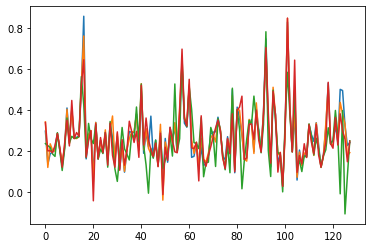

In [73]:
# plotting the first three normal data points
plt.plot(mal_test_data[0])
plt.plot(mal_test_data[1])
plt.plot(mal_test_data[3])
# plt.plot(mal_test_data[4])
plt.plot(mal_test_data[5])
# plt.plot(mal_test_data[2])

In [74]:
normal_test_data[4]

array([0.27087591, 0.14700543, 0.48559247, 0.20660207, 0.26262042,
       0.31100371, 0.19276132, 0.15235092, 0.21170869, 0.32756125,
       0.22678172, 0.29930337, 0.32976803, 0.17940014, 0.26684774,
       0.45407439, 0.21593515, 0.17223346, 0.20440697, 0.29822448,
       0.15213633, 0.33100301, 0.15965345, 0.20386464, 0.2107242 ,
       0.30053865, 0.31426611, 0.27690621, 0.24458149, 0.206016  ,
       0.15193026, 0.15512218, 0.23672148, 0.18485828, 0.19780235,
       0.32219904, 0.29687852, 0.27250235, 0.24023028, 0.22468856,
       0.51340468, 0.16291045, 0.20203531, 0.26852481, 0.27876226,
       0.16912025, 0.24324559, 0.12787546, 0.26831921, 0.18627722,
       0.27446224, 0.2025069 , 0.26968556, 0.2050313 , 0.15071783,
       0.2349002 , 0.36475594, 0.54744635, 0.34482533, 0.29588662,
       0.23460994, 0.20104163, 0.25183819, 0.26056129, 0.11523594,
       0.23674071, 0.17675043, 0.15129611, 0.22000257, 0.25826892,
       0.26299553, 0.2513077 , 0.42026614, 0.27646424, 0.16636

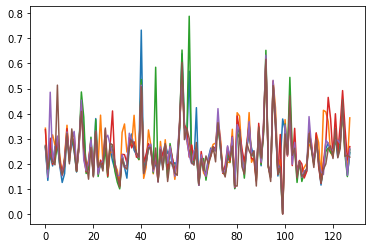

In [75]:
plt.plot(normal_test_data[0])
plt.plot(normal_test_data[1])
plt.plot(normal_test_data[2])
plt.plot(normal_test_data[3])
plt.plot(normal_test_data[4])
plt.plot(normal_test_data[5])

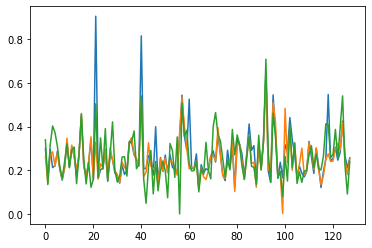

In [76]:
# plotting the first three anomaly data points
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])

In [77]:
class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Sequential([
                                Dense(128, activation='tanh'),
#                                 Dense(32, activation='relu'),
                                Dense(64, activation='tanh'),
#                                 Dense(8, activation='relu')
    ])

    self.decoder = Sequential([
                               Dense(64, activation='tanh'),
#                                Dense(32, activation='rel'),
                               Dense(128, activation='tanh'),
    ])

  def call(self,x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [78]:
# class Autoencoder(Model):
#   def __init__(self):
#     super(Autoencoder, self).__init__()
#     self.encoder = Sequential([
#                                 Dense(128, activation='tanh'),
#                                 Dense(64, activation='tanh'),
#                                 Dense(32, activation='tanh'),
#                                 Dense(16, activation='tanh'),
#                                 Dense(8, activation='tanh')
#     ])

#     self.decoder = Sequential([
#                                Dense(16, activation='tanh'),
#                                Dense(32, activation='tanh'),
#                                Dense(64, activation='tanh'),
#                                Dense(128, activation='tanh')
                            
#     ])

#   def call(self,x):
#     encoded = self.encoder(x)
#     decoded = self.decoder(encoded)
#     return decoded

In [79]:
# Instantiating the Autoencoder
model = Autoencoder()

# creating an early_stopping
# early_stopping = EarlyStopping(monitor='val_loss',
#                                patience = 20,
#                                mode = 'min')
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1, 
    mode='min',
    restore_best_weights=True)
# Compiling the model
model.compile(optimizer = 'adam',
              loss = 'mae')

# model.compile(optimizer = 'adam',
#               loss = 'mse')

In [80]:
len(normal_train_data)

10000

In [81]:
# Training the model
validate = np.concatenate((normal_train_data, normal_val_data), axis=0)

history = model.fit(normal_train_data,normal_train_data,
                    epochs = 500,
                    batch_size = 128,
                    validation_data = (validate,validate),
                    shuffle = True,
                    callbacks = [early_stopping])

Epoch 1/500
79/79 [==============================] - 1s 3ms/step - loss: 0.0656 - val_loss: 0.0332
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0294
Epoch 3/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0281
Epoch 4/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0276
Epoch 5/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.0268
Epoch 6/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0259
Epoch 7/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0254
Epoch 8/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0258
Epoch 9/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0250
Epoch 10/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.0250
Epoch 11/

79/79 [==============================] - 0s 2ms/step - loss: 0.0163 - val_loss: 0.0168
Epoch 84/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0164 - val_loss: 0.0162
Epoch 85/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0162
Epoch 86/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0162 - val_loss: 0.0173
Epoch 87/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 88/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0159
Epoch 89/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0161
Epoch 90/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 91/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 92/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0157 - val_loss: 0.0157
Epoch 93/500


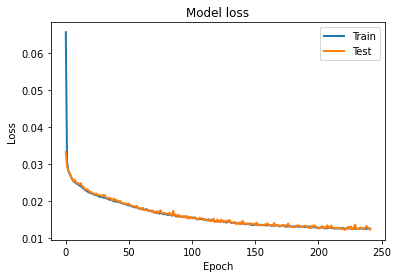

In [82]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [83]:
# predictions for normal test data points
encoder_out = model.encoder(normal_val_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()


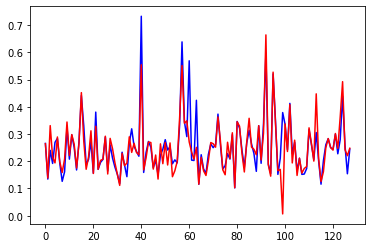

In [84]:
# plotting normal test data point and its predictiction by the autoencoder
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')

In [85]:
# predictions for anomaly test data points
encoder_out_a = model.encoder(mal_test_data).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()

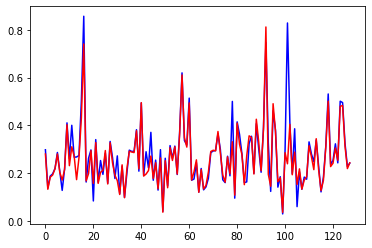

In [86]:
# plotting anomaly test data point and its predictiction by the autoencoder
plt.plot(mal_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')

In [87]:
# reconstruction loss for anomaly test data
reconstructions_a = model.predict(val_data)
val_loss = tf.keras.losses.mae(reconstructions_a, val_data)

# Plotting histogram for recontruction loss for anomaly test data
# plt.hist(train_loss_a, bins = 20)

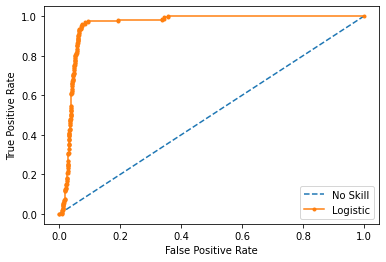

In [88]:
# feature scaling
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
prob_val = (val_loss-min(val_loss))/(max(val_loss)-min(val_loss))

fpr, tpr, thresholds = roc_curve(labels_val,prob_val)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.322617, G-Mean=0.944


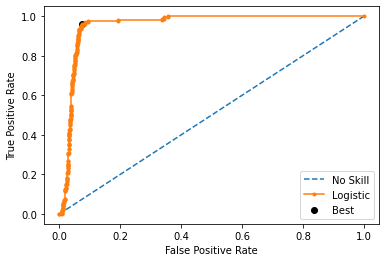

In [89]:
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
threshold = thresholds[ix]

In [90]:
auc = roc_auc_score(labels_val, prob_val, average=None)
auc

0.9551443037974684

In [91]:
# Number of correct predictions for Normal test data  


In [92]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
pred_val = [0 if prob_val[i] < threshold else 1 for i in range(len(prob_val))]
print(roc_auc_score(labels_val, pred_val, average=None))
print(classification_report(labels_val, pred_val, labels=[0, 1], target_names=['benign', 'malicious']))
print(confusion_matrix(labels_val, pred_val))

0.9438126582278481
              precision    recall  f1-score   support

      benign       1.00      0.93      0.96      5000
   malicious       0.29      0.96      0.45       158

    accuracy                           0.93      5158
   macro avg       0.64      0.94      0.70      5158
weighted avg       0.98      0.93      0.94      5158

[[4628  372]
 [   6  152]]


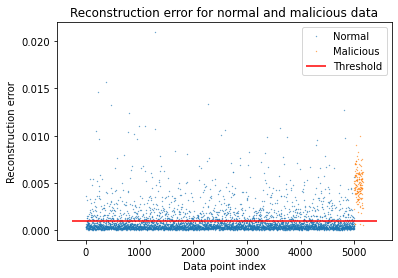

In [30]:
threshold_fixed = 0.001
val_x_predictions = model.predict(val_data)
mse = np.mean(np.power(val_data - val_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': labels_val})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=0.3, linestyle='',
            label= "Malicious" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and malicious data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index") 
plt.show();

In [31]:
reconstructions_a = model.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions_a, test_data)

In [63]:
prob_test = (test_loss-min(test_loss))/(max(test_loss)-min(test_loss))
precision, recall, thresholds = precision_recall_curve(labels_test,prob_test)
f1_scores = 2*recall*precision/(recall+precision)
f1_scores = np.nan_to_num(f1_scores)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))
threshold = thresholds[np.argmax(f1_scores)]

Best threshold:  0.20810809543176725
Best F1-Score:  0.4714038128249567


<ipython-input-63-fed8cf2a95a9>:3: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*recall*precision/(recall+precision)


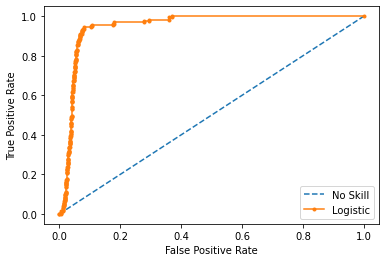

Best Threshold=0.181380, G-Mean=0.931


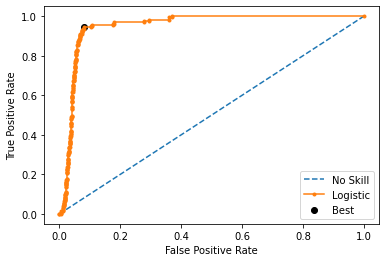

In [60]:
# feature scaling
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
prob_test = (test_loss-min(test_loss))/(max(test_loss)-min(test_loss))

fpr, tpr, thresholds = roc_curve(labels_test,prob_test)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()
threshold = thresholds[ix]



In [64]:
# Number of correct predictions for Normal test data  
prob_test = (test_loss-min(test_loss))/(max(test_loss)-min(test_loss))
print(roc_auc_score(labels_test, prob_test, average=None))
pred_test = [0 if prob_test[i] < threshold else 1 for i in range(len(prob_test))]
len(pred_test)

0.9495245283018868


5159

In [62]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print("Test Evaluation")
print(roc_auc_score(labels_test, pred_test, average=None))
print(classification_report(labels_test ,pred_test,  labels=[0, 1]))
print(confusion_matrix(labels_test ,pred_test))

Test Evaluation
0.9312981132075472
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      5000
           1       0.27      0.94      0.42       159

    accuracy                           0.92      5159
   macro avg       0.63      0.93      0.69      5159
weighted avg       0.98      0.92      0.94      5159

[[4596  404]
 [   9  150]]


In [65]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
print("Test Evaluation")
print(roc_auc_score(labels_test, pred_test, average=None))
print(classification_report(labels_test ,pred_test,  labels=[0, 1]))
print(confusion_matrix(labels_test ,pred_test))

Test Evaluation
0.8994729559748428
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      5000
           1       0.33      0.86      0.47       159

    accuracy                           0.94      5159
   macro avg       0.66      0.90      0.72      5159
weighted avg       0.97      0.94      0.95      5159

[[4718  282]
 [  23  136]]


In [756]:
(153/(153+6))*100

96.22641509433963

In [757]:
(4366/(4366+634))*100

87.32

# Evaluate

In [121]:
# Convert from embeding to path
test_path = [for i in test_data]

array([[0.45665696, 0.30419475, 0.23859148, ..., 0.47777674, 0.28851694,
        0.20919354],
       [0.19869913, 0.26559103, 0.2163514 , ..., 0.26729259, 0.17766782,
        0.16682273],
       [0.21218109, 0.27349976, 0.23470981, ..., 0.2550821 , 0.17282959,
        0.15539351],
       ...,
       [0.22558461, 0.27413348, 0.21736546, ..., 0.3953389 , 0.17753736,
        0.14880978],
       [0.26623092, 0.22878777, 0.20368119, ..., 0.34101772, 0.19337243,
        0.16216949],
       [0.23080367, 0.27827957, 0.16162048, ..., 0.33364048, 0.24645041,
        0.147747  ]])

In [126]:
normal_train_data

array([[0.22929316, 0.26859391, 0.23046819, ..., 0.26320782, 0.2354387 ,
        0.1552757 ],
       [0.22072813, 0.28528531, 0.22496687, ..., 0.260436  , 0.18980082,
        0.17718968],
       [0.21543472, 0.26724119, 0.18339283, ..., 0.25796336, 0.16930908,
        0.14257667],
       ...,
       [0.220926  , 0.2445284 , 0.24389206, ..., 0.24457252, 0.18872352,
        0.15592324],
       [0.21128894, 0.24375516, 0.18633271, ..., 0.28429866, 0.1730248 ,
        0.13807111],
       [0.20916745, 0.23888496, 0.21673308, ..., 0.31409363, 0.17707142,
        0.15180363]])

In [128]:
normal[out_normal_dict[i] for i in out_train_keys_sample]


[tensor([ 4.6619e-03,  1.6932e-03,  3.1425e-03,  2.3987e-03,  7.8718e-03,
          1.0753e-02,  7.9889e-03, -1.8814e-03,  1.3490e-02, -2.8276e-03,
          4.4763e-04,  9.8107e-03,  5.5082e-03,  9.7569e-03,  3.3823e-03,
          1.0061e-02,  2.4589e-01,  1.5538e-04,  9.6670e-02,  3.0817e-04,
         -1.8084e-03,  3.8754e-02,  3.4530e-02, -2.8787e-03,  9.4138e-03,
         -2.4843e-04,  1.6029e-02, -9.4446e-05,  1.1136e-03,  3.8022e-03,
          7.3783e-04,  1.0856e-03,  2.9499e-03, -2.7537e-04,  1.8588e-02,
          3.2225e-03,  2.1665e-04, -1.5964e-03,  1.4330e-03,  1.0512e-02,
         -5.2687e-04,  1.1887e-02,  1.3201e-02,  2.0183e-03,  5.2675e-05,
          1.5655e-02, -2.2900e-02,  2.8790e-02,  4.2689e-04,  2.9776e-03,
          5.3321e-03,  2.5153e-04,  7.2361e-03,  2.1233e-03,  7.3698e-03,
          1.9925e-02,  7.3155e-03,  2.7819e-01,  5.0863e-02, -2.3767e-03,
         -3.4653e-02,  5.2988e-03, -6.6492e-03,  1.3099e+00,  3.9459e-02,
          4.2484e-03,  1.1818e-03, -2.

In [125]:
normal_train_dict = {out_normal_dict[i]:i for i in out_train_keys_sample}
normal_test_dict = {out_normal_dict[i]:i for i in out_test_keys_sample}
normal_val_dict = {out_normal_dict[i]:i for i in out_val_keys_sample}

mal_test_dict = {out_mal_test_dict[i]:i for i in out_mal_test_dict}
mal_val_dict = {out_mal_train_val_dict[i]:i for i in out_mal_train_val_dict}

data_dict = {}
data_dict = {**normal_train_dict, **normal_test_dict}
data_dict = {**data_dict, **normal_val_dict}
data_dict = {**data_dict, **mal_test_dict}
data_dict = {**data_dict, **mal_val_dict}


train_path = [data_dict[i] for i in normal_train_data]
# out_train_dict_sample = {out_normal_dict[i]:i for i in out_train_keys_sample}
train_path


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
def get_false_positive(pred, labels, embedding, data_dict):
    user = []
    computer = []
    path = []
    
    
    
    
    
    return path









In [461]:
temp = torch.Tensor(3,2)
temp

tensor([[-1.2710e-09,  3.0780e-41],
        [ 1.1244e-33,  3.0781e-41],
        [ 4.4842e-44,  0.0000e+00]])

In [236]:
for i in temp:
    print(i)

tensor([-1.3277e-22,  3.0780e-41])
tensor([-8.7377e-19,  3.0780e-41])
tensor([1.1210e-43, 0.0000e+00])


In [ ]:
# Training the model
history = model.fit(normal_train_data,normal_train_data,
                    epochs = 50,
                    batch_size = 128,
                    validation_data = (train_data_scaled[:,1:], train_data_scaled[:,1:]),
                    shuffle = True,
                    callbacks = [early_stopping])

In [39]:
# predictions for normal test data points
encoder_out = model.encoder(normal_val_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()

In [40]:
encoder_out.shape

(4997, 8)

In [41]:
decoder_out.shape

(4997, 128)

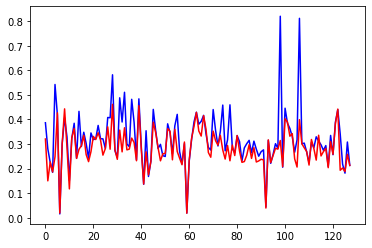

In [42]:
# plotting normal test data point and its predictiction by the autoencoder
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')

In [43]:
# predictions for anomaly test data points
encoder_out_a = model.encoder(mal_test_data).numpy()
decoder_out_a = model.decoder(encoder_out_a).numpy()

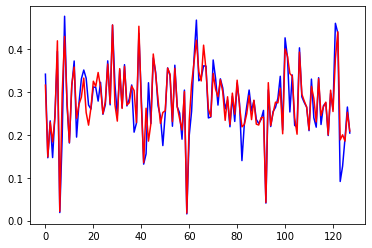

In [44]:
# plotting anomaly test data point and its predictiction by the autoencoder
plt.plot(mal_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]]),
 array([0.00867242, 0.01720177, 0.02573112, 0.03426048, 0.04278983,
        0.05131919, 0.05984854, 0.06837789, 0.07690725, 0.0854366 ,
        0.09396596]),
 <a list of 4998 BarContainer objects>)

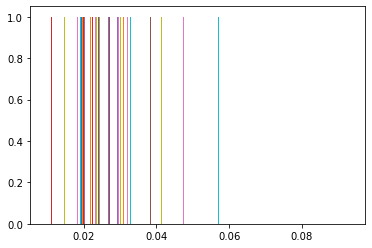

In [45]:
# reconstruction loss for normal test data
reconstructions = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_test_data)

# Plotting histogram for recontruction loss for normal test data
plt.hist(train_loss, bins = 10)

In [46]:
np.mean(train_loss)

0.024661725968090385

In [47]:
np.std(train_loss)

0.01050129499984465

(array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.01967302, 0.02231314, 0.02495327, 0.02759339, 0.03023351,
        0.03287363, 0.03551375, 0.03815387, 0.04079399, 0.04343412,
        0.04607424]),
 <a list of 159 BarContainer objects>)

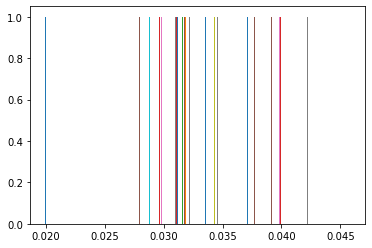

In [48]:
# reconstruction loss for anomaly test data
reconstructions_a = model.predict(mal_test_data)
train_loss_a = tf.keras.losses.mae(reconstructions_a, mal_test_data)

# Plotting histogram for recontruction loss for anomaly test data
plt.hist(train_loss_a, bins = 10)

In [55]:
np.mean(train_loss_a)

0.032920637652143814

In [54]:
np.std(train_loss_a)

0.0046078258096637174

In [53]:
np.mean(train_loss_a)

0.032920637652143814

In [52]:
# setting threshold
# threshold = np.mean(train_loss) + 2*np.std(train_loss)
threshold = (np.mean(train_loss) +np.mean(train_loss_a))/2
threshold

0.028791181810117097

0.028791181810117097

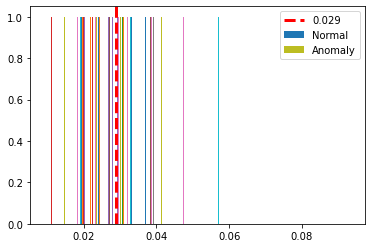

In [56]:
# Plotting the normal and anomaly losses with the threshold
plt.hist(train_loss, bins = 10, label = 'Normal')
plt.hist(train_loss_a, bins = 10, label = 'Anomaly')
plt.axvline(threshold, color='r', linewidth = 3, linestyle = 'dashed', label = '{:0.3f}'.format(threshold))
plt.legend(loc = 'upper right')
plt.show()

In [59]:
# Number of correct predictions for Normal test data  
preds = tf.math.less(train_loss, threshold)
preds

<tf.Tensor: shape=(4998,), dtype=bool, numpy=array([False, False,  True, ..., False,  True,  True])>

In [60]:
tf.math.count_nonzero(preds)

<tf.Tensor: shape=(), dtype=int64, numpy=3821>

In [61]:
# Number of correct predictions for Anomaly test data 
preds_a = tf.math.greater(train_loss_a, threshold)

In [62]:
tf.math.count_nonzero(preds_a)

<tf.Tensor: shape=(), dtype=int64, numpy=137>

In [63]:
preds_a.shape

TensorShape([159])

In [125]:
malicious_path = list(torch.load("/home/andrewngo/Desktop/MLTracker/malicious_CUC_path.pt"))
malicious_path

[(9605, 11336, 6755),
 (9605, 11336, 3255),
 (9605, 11336, 12151),
 (9605, 11336, 1781),
 (9605, 11336, 3111),
 (9605, 11336, 9774),
 (9605, 11336, 7132),
 (9605, 11336, 5829),
 (9605, 11336, 9621),
 (9605, 11336, 4526),
 (9605, 11336, 11845),
 (9605, 11336, 2976),
 (9605, 11336, 105),
 (9605, 11336, 9648),
 (9605, 11336, 6359),
 (9605, 16, 6399),
 (9605, 2304, 512),
 (9605, 11336, 226),
 (9605, 11336, 8439),
 (9605, 11336, 7127),
 (9605, 11336, 64),
 (9605, 11336, 3865),
 (9605, 11336, 2315),
 (9605, 11336, 2562),
 (9605, 11336, 8987),
 (9605, 11336, 356),
 (9605, 11336, 9243),
 (9605, 16, 6156),
 (9605, 11336, 4642),
 (9605, 11336, 877),
 (9605, 11336, 10649),
 (11239, 11336, 30),
 (9605, 11336, 221),
 (9605, 11336, 6219),
 (9605, 11336, 2683),
 (9605, 11336, 7122),
 (9605, 11336, 8452),
 (9605, 11336, 7131),
 (9605, 11336, 50),
 (9605, 11336, 11826),
 (9605, 11336, 3851),
 (9605, 11336, 6075),
 (9605, 11336, 8061),
 (9605, 11336, 4763),
 (9605, 11336, 827),
 (9605, 11336, 598),
 (96

In [ ]:
def ([user1,user2]):
    
